<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow%202.png'>

## 👋🏽 What's up! Welcome to the tutorial, where you'll learn how to use [SuperGradients](https://github.com/Deci-AI/super-gradients) with the YOLO-NAS-Pose model from [Deci AI](https://deci.ai/).


At any point, if you get stuck or have questions, there are three ways to get in touch:

1) Send me an email with your issue: harpreet.sahota@deci.ai

2) Hop into the [Deep Learning Daily (powered by Deci) Discord server](https://discord.gg/p9ecgRhDR8), and let us know what your question is.

3) [Open an issue on GitHub](https://github.com/Deci-AI/super-gradients/issues/new/choose)


In [ ]:
# @title Some hacks to to deal with known Colab issues

import locale

# This hack is to prevent occasional issue in Colab https://github.com/googlecolab/colabtools/issues/3409
locale.getpreferredencoding = lambda *args: "UTF-8"

In [1]:
!pip install -qq super-gradients==3.6.0 gdown

  Preparing metadata (setup.py) ... done


In [2]:
# @title Some standard imports
# Standard library imports
import json
import os
import random
from pathlib import Path
from typing import Any, List, Tuple, Union

# Third-party imports
import gdown
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from sklearn.model_selection import train_test_split

# Colab specific imports

# Constants
device = "cuda" if torch.cuda.is_available() else "cpu"

# 🦸🏾‍♂️ SuperGradients

SuperGradients is a PyTorch based training library.

It provides a uniform interface for the most common computer vision use cases:

- Classification

- Detection

- Segmentation

- Pose estimation

There are nearly 40 pretrained models in our model zoo. You can see the pretrained models available to you by following [this link](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/model_zoo.md).

This notebook will focus on using SuperGradients with YOLO-NAS Pose. From this notebook you will learn how to train your own pose estimation model by fine-tuning YoloNAS Pose on a custom dataset.

# 🫣 Sneak peek: Inference with YOLO-NAS-Pose

Before jumping into the section on fine-tuning, I wanted to show you the power of YOLO-NAS-Pose out of the box.

Start by instantiating a pretrained model. YOLO-NAS-Pose comes in three flavors: `yolo_nas_pose_s`, `yolo_nas_pose_m`, and `yolo_nas_pose_l`.

You'll use `yolo_nas_pose_l` throughout this notebook. Because you should always go big, or go home.

It's a good life philosophy.

In [3]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

yolo_nas_pose = models.get("yolo_nas_pose_m", pretrained_weights="coco_pose").cuda()

The console stream is logged into /root/sg_logs/console.log


[2024-02-12 10:05:59] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-02-12 10:06:00] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-02-12 10:06:00] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-02-12 10:06:14] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-12 10:06:14] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-12 10:06:14] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-02-12 10:06:16] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-12 10:06:16] INFO - checkpoint_utils.py - Successfully loaded pretrained 

## 🖼️ Inference on an image

Once the model has been instantiated all you have to do is call the `predict` method.

This method operates on:
* PIL Image
* Numpy Image
* A path to image file
* A path to video file
* A path to folder with images
* URL (Image only)

Allowing you to perform inference with ease.

Note predict also has an argument called `conf`, which is the threshold for a detection. You change this value as you like, for example `model.predict("path/to/asset",conf=0.25)`

Let's perform inference on the following image:

<img src='https://rockynook.com/wp-content/uploads/2015/10/Male-Posing-Chart-612x1024.jpg'>


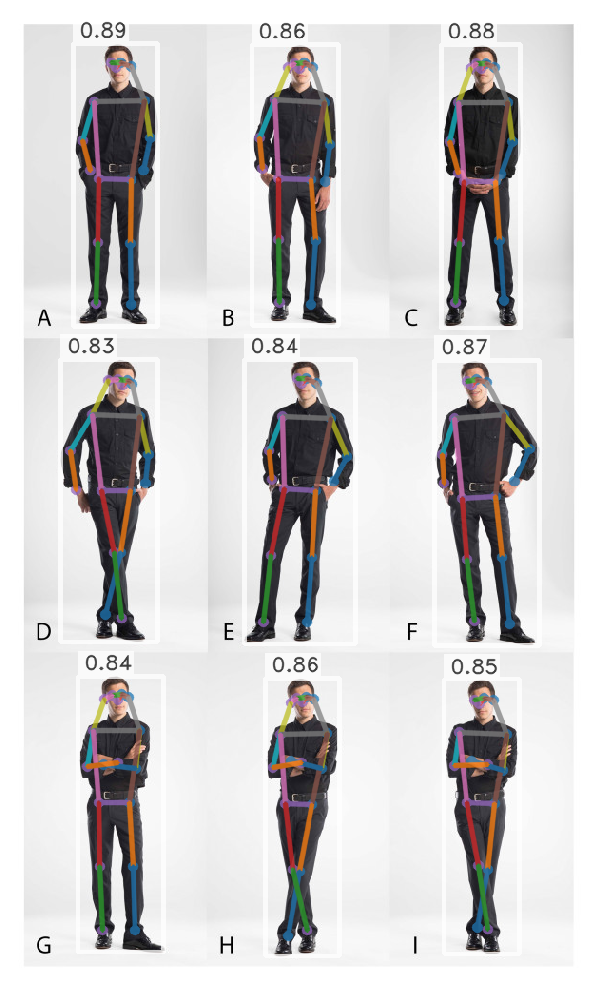

In [4]:
url = "https://rockynook.com/wp-content/uploads/2015/10/Male-Posing-Chart-612x1024.jpg"
yolo_nas_pose.predict(url, conf=0.70, fuse_model=False).show()

### 🤷🏽‍♂️ What's happening "under the hood"

1. Input image gets through the preprocessing pipeline, which includes image resizing, normalization and permute operation to convert input RGB image to torch tensor.
2. Model inference
3. Postprocessing of the detection results (Non-maximum suppression, resizing bounding boxes to the size of original image)
4. Visualization of the results (Rendering of bounding boxes and keypoints on top of the image)

# 🪡 Fine-tuning YOLO-NAS-Pose

## 🏋🏽 The trainer

The first thing you need to define in SuperGradients is the Trainer.

The trainer is in charge of training, evaluation, saving checkpoints, etc. If you're interested in seeing the source code for the trainer, you can do so [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/sg_trainer/sg_trainer.py).

### ✌🏼 There's two important arguments to the trainer:

1) `ckpt_root_dir` - this is the directory where results from all your experiments will be saved

2)`experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

SuperGradients supports **Data Parallel** and **Distributed Data Parallel**.

That's outside of the scope for this introduction to SuperGradients. But, if you're fortunate enough to have multiple GPUs at your disposal or want learn more you can do so [here](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/device.md#3-dp---data-parallel).

In the code below, you'll instantiate the trainer with just a single GPU (since that's what Google Colab provides)

In [5]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = "checkpoints"
trainer = Trainer(experiment_name="my_first_yn_pose_run", ckpt_root_dir=CHECKPOINT_DIR)

# ⤵️ Download Dataset Animal Pose Estimation Dataset

This dataset offers animal pose annotations for:

- 🐶 Dog

- 🐱 Cat

- 🐄 Cow

- 🐎 Horse

- 🐑 Sheep

In total, it includes over 6,000 instances in more than 4,000 images. Additionally, the dataset provides bounding box annotations for another 7 animal categories. Detailed information can be found in the associated paper.

Keypoints annotated are 20 in total: Two eyes, Throat, Nose, Withers, Two Earbases, Tailbase, Four Elbows, Four Knees, and Four Paws.

In [6]:
# @title Dowloading the Animal Pose Dataset
dataset_id = "1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF"
annotations_id = "1bAidtvR3MttetncXz0mfr47vYy7Uf5hm"

file_ids = [dataset_id, annotations_id]

for id in file_ids:
    url = f"https://drive.google.com/uc?id={id}"
    gdown.download(url, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF
From (redirected): https://drive.google.com/uc?id=1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF&confirm=t&uuid=c1a453a2-3e0c-4543-93b2-89b16e588d8a
To: /content/images.zip
100%|██████████| 368M/368M [00:03<00:00, 117MB/s] 


In [7]:
# @title

!unzip -qo /content/images.zip

Downloading...
From: https://drive.google.com/uc?id=1bAidtvR3MttetncXz0mfr47vYy7Uf5hm
To: /content/keypoints.json
100%|██████████| 2.36M/2.36M [00:00<00:00, 15.1MB/s]


In [8]:
# @title
def open_file(file_path: str) -> Union[dict, list, None]:
    """
    Opens and reads the content of a JSON or YAML file.

    Parameters:
    file_path (str): The path to the file.

    Returns:
    Union[dict, list, None]: The content of the file parsed to a dictionary or a list,
                             or None if an error occurs.
    """
    try:
        with open(file_path, "r") as file:
            if file_path.endswith(".json"):
                return json.load(file)
            elif file_path.endswith(".yaml") or file_path.endswith(".yml"):
                return yaml.safe_load(file)
            else:
                raise ValueError(f"Unsupported file format: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


# Usage:
annotations = open_file("/content/keypoints.json")

# Annotation File Breakdown

Each image is annotated with keypoints indicating specific parts of the animal, and these keypoints are categorized under different animal categories. The dataset also provides a skeleton structure, indicating how the keypoints are connected for each animal category.

### The dictionary has the following keys and values:

### 1. **images**:
   - It's a dictionary where each entry maps an ID to a filename (typically an image filename). Each image in the dataset has a unique identifier, and this is a lookup between the ID and the filename.

### 2. **annotations**:
   - This is a list containing 6,117 items. Each item is a dictionary with details related to the annotations for a particular image.
   - Each annotation contains an `image_id`, a list of `keypoints`, and `num_keypoints` value.

### 3. **categories**:
   - A list of categories for the dataset.
   - Each category has a:
     - `supercategory`: A broader classification (like 'animal').
     - `id`: A unique identifier for the category.
     - `name`: The name of the category (e.g., 'dog', 'cat', 'sheep').
     - `keypoints`: A list of names for specific keypoints relevant to that category (like 'left_eye', 'right_eye', 'nose', etc.).
     - `skeleton`: A list of pairs, which are connections between keypoints.



In [9]:
# @title Plotting a sample of images


def plot_random_images(data=annotations, image_base_dir="/content/images"):
    """
    Plots 5 random images for each category from the provided dataset.

    Parameters:
    - data: The JSON dataset containing image, annotation, and category details.
    - image_base_dir: The base directory where the images are located.
    """

    # Extracting image_ids for each category
    category_image_ids = {}
    for category in data["categories"]:
        category_id = category["id"]
        category_name = category["name"]
        category_image_ids[category_name] = [anno["image_id"] for anno in data["annotations"] if anno["category_id"] == category_id]

    # Randomly select 5 image_ids for each category
    random_selected_ids = {}
    for category_name, ids in category_image_ids.items():
        random_selected_ids[category_name] = random.sample(ids, min(5, len(ids)))

    # Create a figure to plot the images
    fig, axes = plt.subplots(len(random_selected_ids), 5, figsize=(20, 15))

    for i, (category_name, ids) in enumerate(random_selected_ids.items()):
        for j, image_id in enumerate(ids):
            # Get the filename from the images dictionary
            filename = data["images"][str(image_id)]
            # Load and plot the image
            img_path = os.path.join(image_base_dir, filename)
            img = mpimg.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(category_name)

    plt.tight_layout()
    plt.show()

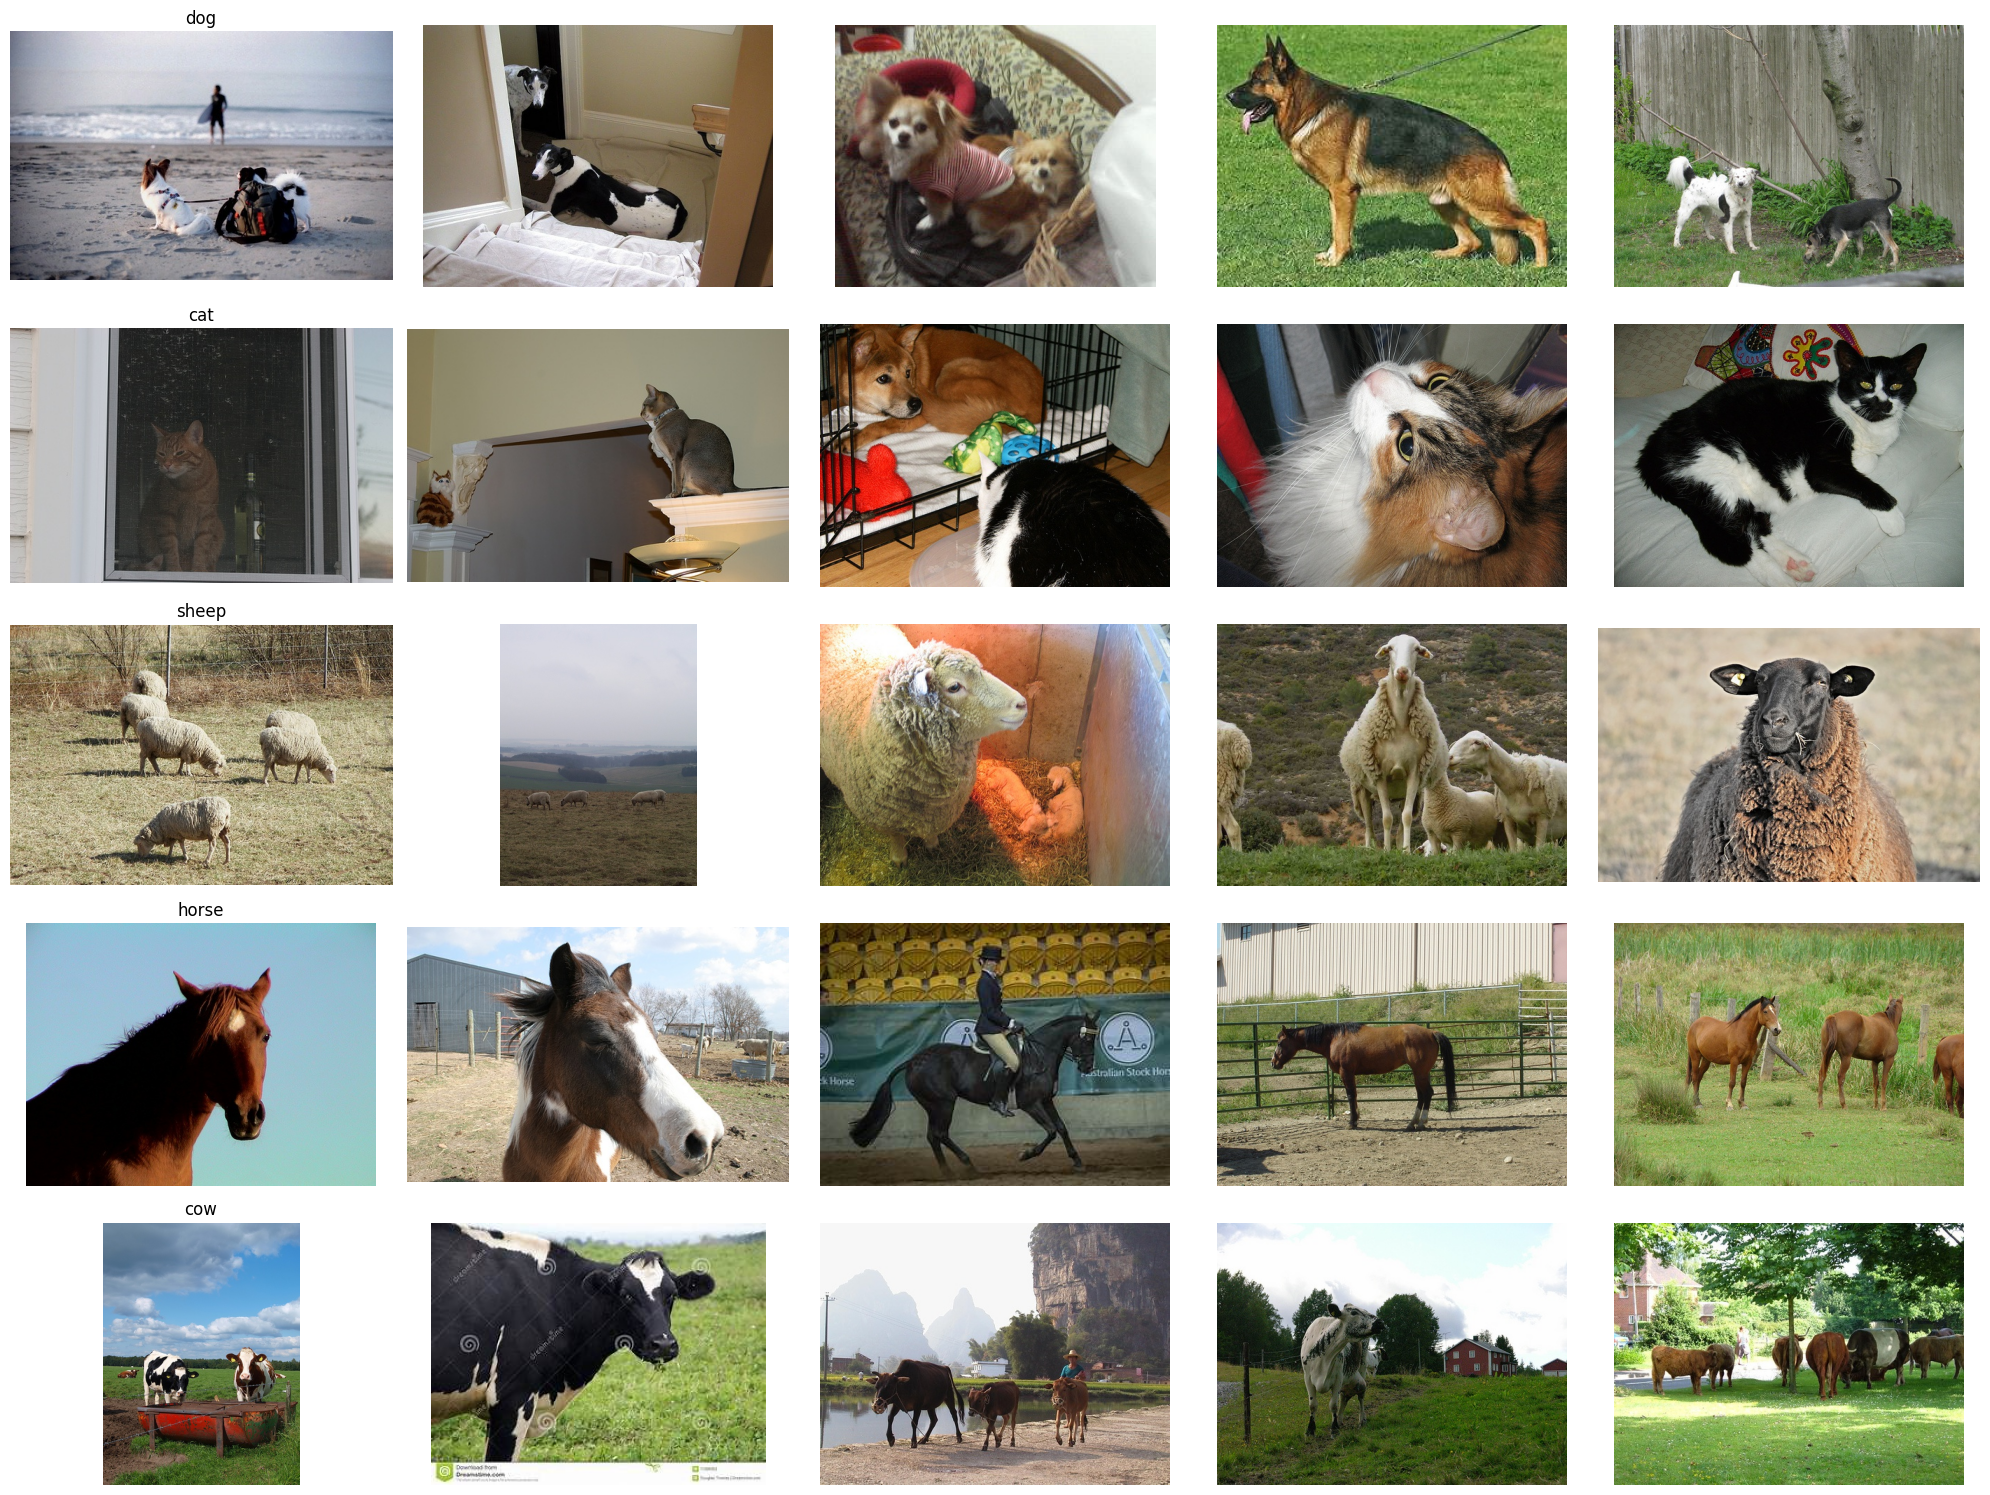

In [10]:
plot_random_images()

# 💾 Datasets and DataLoaders

SuperGradients is fully compatible with PyTorch Datasets and Dataloaders, so you can use your dataloaders as is.

### SuperGradients also provides you with the `AbstractPoseEstimationDataset` class.

This is an abstract class defines a blueprint for datasets related to pose estimation tasks. It's expected that concrete implementations of this class will be created for specific datasets.

- **Inheritance**: It inherits from PyTorch's `Dataset` and `HasPreprocessingParams`.

- **Initialization**:
  - Takes in parameters like `transforms`, `num_joints`, `edge_links`, `edge_colors`, and `keypoint_colors`.
  - Initializes instance variables and constructs a transform pipeline (`KeypointsCompose`).

- **Abstract Methods (`__len__` and `load_sample`)**:
  - These methods are declared but don't have a concrete implementation in this class. Your derived class from this abstract class is expected to provide an implementation for these methods.
  
- **`load_random_sample` Method**:
  - This method is used to fetch a random sample from the dataset. It uses the `__len__` method to get the total number of samples and then randomly selects an index to retrieve using `load_sample`.

- **`__getitem__` Method**:
  - This method retrieves a sample given its index. It then applies the defined transformations on the sample and returns it. This method is crucial for PyTorch's DataLoader to fetch samples during training.

- **`get_dataset_preprocessing_params` Method**:
  - This method defines and returns preprocessing parameters for the dataset. It seems to construct a pipeline of preprocessing steps and their parameters.


In [11]:
# @title Expand this cell to see how the `AnimalPoseEstimationDataset` is implemented
from super_gradients.common.decorators.factory_decorator import resolve_param
from super_gradients.common.factories.transforms_factory import TransformsFactory
from super_gradients.training.transforms.keypoint_transforms import AbstractKeypointTransform
from super_gradients.training.samples import PoseEstimationSample

from super_gradients.training.utils.distributed_training_utils import wait_for_the_master
from super_gradients.common.environment.ddp_utils import get_local_rank
from super_gradients.training.datasets.pose_estimation_datasets.abstract_pose_estimation_dataset import AbstractPoseEstimationDataset

from super_gradients.training.datasets.pose_estimation_datasets import YoloNASPoseCollateFN


class AnimalPoseEstimationDataset(AbstractPoseEstimationDataset):
    """
    Dataset class for training pose estimation models on Animal Pose dataset.
    """

    @classmethod
    def split_animal_pose_dataset(cls, annotation_file: str, train_annotation_file: str, val_annotation_file: str, val_fraction: float):
        """
        Split the Animal Pose dataset into training and validation sets.

        :param annotation_file: Path to the JSON file containing all annotations.
        :param train_annotation_file: Path where the annotations for the training set will be saved.
        :param val_annotation_file: Path where the annotations for the validation set will be saved.
        :param val_fraction: Fraction of the total dataset to be used for validation.
        """
        # Open and load the entire annotations JSON file
        with open(annotation_file, "r") as f:
            annotation = json.load(f)

        # Extract image IDs from the annotations
        image_ids = list(annotation["images"].keys())

        # Extract labels for each image to be used for stratified splitting
        # (ensures a balanced class distribution in train and validation sets)
        labels = [[ann["category_id"] for ann in annotation["annotations"] if ann["image_id"] == image_id] for image_id in image_ids]
        labels = [label[0] if len(label) else -1 for label in labels]  # Choose the first label if present, else assign -1

        # Split the dataset into training and validation sets
        train_ids, val_ids = train_test_split(image_ids, test_size=val_fraction, random_state=42, stratify=labels)

        # Prepare annotations dictionary for training set
        train_annotations = {
            "info": annotation["info"],
            "categories": annotation["categories"],
            "images": dict((image_id, annotation["images"][image_id]) for image_id in train_ids),
            "annotations": [ann for ann in annotation["annotations"] if str(ann["image_id"]) in train_ids],
        }

        # Prepare annotations dictionary for validation set
        val_annotations = {
            "info": annotation["info"],
            "categories": annotation["categories"],
            "images": dict((image_id, annotation["images"][image_id]) for image_id in val_ids),
            "annotations": [ann for ann in annotation["annotations"] if str(ann["image_id"]) in val_ids],
        }

        # Save the annotations for the training set to a JSON file
        with open(train_annotation_file, "w") as f:
            json.dump(train_annotations, f)
            print("Train annotations saved to", train_annotation_file)
            print("Train images:", len(train_ids))
            print("Train annotations:", len(train_annotations["annotations"]))

        # Save the annotations for the validation set to a JSON file
        with open(val_annotation_file, "w") as f:
            json.dump(val_annotations, f)
            print("Val annotations saved to", val_annotation_file)
            print("Val images:", len(val_ids))
            print("Val annotations:", len(val_annotations["annotations"]))

    @resolve_param("transforms", TransformsFactory())
    def __init__(
        self,
        data_dir: str,
        images_dir: str,
        json_file: str,
        transforms: List[AbstractKeypointTransform],
        edge_links: Union[List[Tuple[int, int]], np.ndarray],
        edge_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
        keypoint_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
    ):
        """

        :param data_dir: Root directory of the COCO dataset
        :param images_dir: path suffix to the images directory inside the data_dir
        :param json_file: path suffix to the json file inside the data_dir
        :param include_empty_samples: Not used, but exists for compatibility with COCO dataset config.
        :param target_generator: Target generator that will be used to generate the targets for the model.
            See DEKRTargetsGenerator for an example.
        :param transforms: Transforms to be applied to the image & keypoints
        """
        split_json_file = os.path.join(data_dir, json_file)
        full_json_file = os.path.join(data_dir, "keypoints.json")

        if not os.path.exists(split_json_file) and os.path.exists(full_json_file):
            with wait_for_the_master(get_local_rank()):
                train_json_file = os.path.join(data_dir, "train_keypoints.json")
                val_json_file = os.path.join(data_dir, "val_keypoints.json")
                self.split_animal_pose_dataset(full_json_file, train_json_file, val_json_file, 0.2)

        with open(split_json_file, "r") as f:
            json_annotations = json.load(f)

        joints = json_annotations["categories"][0]["keypoints"]
        num_joints = len(joints)

        super().__init__(
            transforms=transforms,
            num_joints=num_joints,
            edge_links=edge_links,
            edge_colors=edge_colors,
            keypoint_colors=keypoint_colors,
        )

        self.num_joints = num_joints

        images_and_ids = [(image_id, os.path.join(data_dir, images_dir, image_path)) for image_id, image_path in json_annotations["images"].items()]
        self.image_ids, self.image_files = zip(*images_and_ids)

        self.annotations = []

        for image_id in self.image_ids:
            keypoints_per_image = []
            bboxes_per_image = []

            image_annotations = [ann for ann in json_annotations["annotations"] if str(ann["image_id"]) == str(image_id)]
            for ann in image_annotations:
                keypoints = np.array(ann["keypoints"]).reshape(self.num_joints, 3)
                x1, y1, x2, y2 = ann["bbox"]

                bbox_xywh = np.array([x1, y1, x2 - x1, y2 - y1])
                keypoints_per_image.append(keypoints)
                bboxes_per_image.append(bbox_xywh)

            keypoints_per_image = np.array(keypoints_per_image, dtype=np.float32).reshape(-1, self.num_joints, 3)
            bboxes_per_image = np.array(bboxes_per_image, dtype=np.float32).reshape(-1, 4)
            annotation = keypoints_per_image, bboxes_per_image
            self.annotations.append(annotation)

    def __len__(self):
        return len(self.image_ids)

    def load_sample(self, index) -> PoseEstimationSample:
        file_path = self.image_files[index]
        gt_joints, gt_bboxes = self.annotations[index]  # boxes in xywh format

        gt_areas = np.array([box[2] * box[3] for box in gt_bboxes], dtype=np.float32)
        gt_iscrowd = np.array([0] * len(gt_joints), dtype=bool)

        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
        mask = np.ones(image.shape[:2], dtype=np.float32)

        return PoseEstimationSample(
            image=image, mask=mask, joints=gt_joints, areas=gt_areas, bboxes_xywh=gt_bboxes, is_crowd=gt_iscrowd, additional_samples=None
        )

Before we proceed it is crucial to discuss a few details that pose estimation datasets differs from let's say object detection or classification ones.

In pose estimation task a goal is to correctly identify the skeleton of the object by regressing coordinates of it's joints (also called keypoints).

So the dataset must contain coordinates of these keypoints and also skeleton structure: a **list of joints**, **connections** between joints and **horisontal symmetry information**.

A **list of joints** defines the order of joints in the annotation file. It usually looks like this: `["left eye", "right eye", "left shoulder, "left arg", ...]`. It sets the order of keypoints.




In [12]:
KEYPOINT_NAMES = [
    "left eye",
    "right eye",
    "nose",
    "left earbase",
    "right earbase",
    "L_F_elbow",
    "R_F_elbow",
    "L_B_elbow",
    "R_B_elbow",
    "L_F_knee",
    "R_F_knee",
    "L_B_knee",
    "R_B_knee",
    "L_F_paw",
    "R_F_paw",
    "L_B_paw",
    "R_B_paw",
    "throat",
    "withers",
    "tailbase",
]

NUM_JOINTS = len(KEYPOINT_NAMES)

KEYPOINT_COLORS = [
    [148, 0, 211],
    [75, 0, 130],
    [0, 0, 255],
    [0, 255, 0],
    [255, 255, 0],
    [255, 165, 0],
    [255, 69, 0],
    [255, 0, 0],
    [139, 0, 0],
    [128, 0, 128],
    [238, 130, 238],
    [186, 85, 211],
    [148, 0, 211],
    [0, 255, 255],
    [0, 128, 128],
    [0, 0, 139],
    [0, 0, 255],
    [0, 255, 0],
    [255, 69, 0],
]

Each keypoint also has it's corresponding **sigma score**. This value describes how "hard" it is to accurately localize the specific keypoint. Certain keypoints, like ear or an eye are quite easy to be annotated while others (Hip or shoulder) are harder and annotators tend to have different views where to put exact coordinate of the keypoint. In case of COCO dataset, "eye" keypoint  have smaller sigma score and "hip" - larger. Sigma scores has direct impact on the training progress as they control how much model is penalized for regression errors.

A scientific way to set those scores is to have multuple annotators annotate a subset of objects and measure standard deviation per each keypoint. If annotating a dataset is not an option one can use use values of ~0.05..0.1 as a good enough approximation.

Please keep in mind that **sigma score** also has direct impact on the computed AP metric. The smaller sigma scores are the lower AP metric would be. So **one should not compare AP scores of models trained with different sigma scores**.


In [13]:
OKS_SIGMAS = [0.07] * NUM_JOINTS

A **connections** or **edge links** i a list of pairs of indexes of keypoints forming bones. This is what connects individual keypoints to a skeleton. It is not used directly for model training but needed for visualization of model predictions.

In [14]:
EDGE_LINKS = [
    [0, 1],
    [0, 2],
    [1, 2],
    [0, 3],
    [1, 4],
    [2, 17],
    [18, 19],
    [5, 9],
    [6, 10],
    [7, 11],
    [8, 12],
    [9, 13],
    [10, 14],
    [11, 15],
    [12, 16],
]

EDGE_COLORS = [
    [127, 0, 255],
    [91, 56, 253],
    [55, 109, 248],
    [19, 157, 241],
    [18, 199, 229],
    [54, 229, 215],
    [90, 248, 199],
    [128, 254, 179],
    [164, 248, 158],
    [200, 229, 135],
    [236, 199, 110],
    [255, 157, 83],
    [255, 109, 56],
    [255, 56, 28],
    [255, 0, 0],
]

Last but not least is **horisontal symmetry information** - in the nutshell it describes how the order of keypoints change if we apply horisontal flip to an image. Given a joints `["left eye", "right eye", "tail" ...]` after flip operation they become `["right eye", "left eye", "tail" ...]`.

<font color="red">**It is crucial to swap symmetic keypoints otherwise the training with horisontal flip augmentatin would not work.**

THE FOLLOWING `FLIP_INDEXES` ARE CORRECT FOR ANIMALPOSE DATASET ONLY.
</font>

For a custom dataset you should update this variable according to semantic meaning of keypoints in your dataset.

In [15]:
FLIP_INDEXES = [1, 0, 2, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15, 17, 18, 19]

In [16]:
# @title Splitting dataset
animal_data = AnimalPoseEstimationDataset(
    data_dir=".",
    images_dir="images",
    json_file="keypoints.json",
    transforms=[],
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,
)

animal_data.split_animal_pose_dataset(
    annotation_file="/content/keypoints.json",
    train_annotation_file="/content/train_keypoints.json",
    val_annotation_file="/content/other_keypoints.json",
    val_fraction=0.20,
)

animal_data.split_animal_pose_dataset(
    annotation_file="/content/other_keypoints.json",
    train_annotation_file="/content/val_keypoints.json",
    val_annotation_file="/content/test_keypoints.json",
    val_fraction=0.50,
)

train_annotations = open_file("/content/train_keypoints.json")
val_annotations = open_file("/content/val_keypoints.json")
test_annotations = open_file("/content/test_keypoints.json")

Train annotations saved to /content/train_keypoints.json
Train images: 3686
Train annotations: 4938
Val annotations saved to /content/other_keypoints.json
Val images: 922
Val annotations: 1179
Train annotations saved to /content/val_keypoints.json
Train images: 461
Train annotations: 572
Val annotations saved to /content/test_keypoints.json
Val images: 461
Val annotations: 607


# KeyPoint Transformations

SuperGradients has a number of transformations for KeyPoints. Take a look at the [source code](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/transforms/keypoints) to see them all and get more detail.

All the the transforms subclass from the [`AbstractKeypointTransform`](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/transforms/keypoints/abstract_keypoints_transform.py) class.




In [17]:
IMAGE_SIZE = 640

In [18]:
# @title Expand this cell to see how the transforms are instantiated
from super_gradients.training.transforms.keypoints import (
    KeypointsRandomHorizontalFlip,
    KeypointsHSV,
    KeypointsBrightnessContrast,
    KeypointsMosaic,
    KeypointsRandomAffineTransform,
    KeypointsLongestMaxSize,
    KeypointsPadIfNeeded,
    KeypointsImageStandardize,
    KeypointsRemoveSmallObjects,
)

# Indexes of keypoints on the flipped image. When doing left-right flip, left hand becomes right hand.
# So this array contains order of keypoints on the flipped image. This is dataset specific and depends on
# how keypoints are defined in dataset.
keypoints_random_horizontal_flip = KeypointsRandomHorizontalFlip(flip_index=FLIP_INDEXES, prob=0.5)

keypoints_hsv = KeypointsHSV(prob=0.5, hgain=20, sgain=20, vgain=20)

keypoints_brightness_contrast = KeypointsBrightnessContrast(prob=0.5, brightness_range=[0.8, 1.2], contrast_range=[0.8, 1.2])

keypoints_mosaic = KeypointsMosaic(prob=0.8)

keypoints_random_affine_transform = KeypointsRandomAffineTransform(
    max_rotation=0, min_scale=0.5, max_scale=1.5, max_translate=0.1, image_pad_value=127, mask_pad_value=1, prob=0.75, interpolation_mode=[0, 1, 2, 3, 4]
)

keypoints_longest_max_size = KeypointsLongestMaxSize(max_height=IMAGE_SIZE, max_width=IMAGE_SIZE)

keypoints_pad_if_needed = KeypointsPadIfNeeded(
    min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, image_pad_value=[127, 127, 127], mask_pad_value=1, padding_mode="bottom_right"
)

keypoints_image_standardize = KeypointsImageStandardize(max_value=255)

keypoints_remove_small_objects = KeypointsRemoveSmallObjects(min_instance_area=1, min_visible_keypoints=1)

### Arguments for `AnimalPoseEstimationDataset`:

The `AnimalPoseEstimationDataset` is being initialized with paths to the data, a list of transformations, and visualization-specific parameters like edge links and colors.


1. **`data_dir`**: Specifies the base directory where the dataset is located.

2. **`images_dir`**: Specifies the sub-directory (relative to `data_dir`) where the images of the dataset are stored.

3. **`json_file`**: Path to the JSON file that contains the annotations for the images.

4. **`transforms`**: A list of transformations (or data augmentations) to apply to the images and their associated keypoints during training. These are detched from the configuration file downloaded earlier. It's instantiated as a dictionary (`config`) with key `'train_dataset_params'` and then further extracting the `'transforms'` key.

5. **`edge_links`**: Specifies the links (or connections) between keypoints. It's a list of pairs where each pair represents a connection between two keypoints. Fetched from the `config` dictionary using the key `'edge_links'`.

6. **`edge_colors`**: Colors for the edge links defined above. Fetched from the `config` dictionary using the key `'edge_colors'`.

7. **`keypoint_colors`**: Specifies the colors for individual keypoints. Fetched from the `config` dictionary using the key `'keypoint_colors'`.




In [19]:
train_transforms = [
    keypoints_random_horizontal_flip,
    keypoints_hsv,
    keypoints_brightness_contrast,
    # You can enable mosaic augmentation if you want. This usually improves the metric at the cost of increased training time
    # keypoints_mosaic,
    keypoints_random_affine_transform,
    keypoints_longest_max_size,
    keypoints_pad_if_needed,
    keypoints_image_standardize,
    keypoints_remove_small_objects,
]

val_transforms = [
    keypoints_longest_max_size,
    keypoints_pad_if_needed,
    keypoints_image_standardize,
]

In [20]:
# Create instances of the dataset
train_dataset = AnimalPoseEstimationDataset(
    data_dir=".",
    images_dir="images",
    json_file="/content/train_keypoints.json",
    transforms=train_transforms,
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,
)

val_dataset = AnimalPoseEstimationDataset(
    data_dir=".",
    images_dir="images",
    json_file="/content/val_keypoints.json",
    transforms=val_transforms,
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,
)

test_dataset = AnimalPoseEstimationDataset(
    data_dir=".",
    images_dir="images",
    json_file="/content/test_keypoints.json",
    transforms=val_transforms,
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,
)

You can also pass PyTorch DataLoaders arguments when instantiating your DataLoadeer.


In [21]:
from torch.utils.data import DataLoader

# Create dataloaders
train_dataloader_params = {"shuffle": True, "batch_size": 24, "drop_last": True, "pin_memory": False, "collate_fn": YoloNASPoseCollateFN()}

val_dataloader_params = {"shuffle": True, "batch_size": 24, "drop_last": True, "pin_memory": False, "collate_fn": YoloNASPoseCollateFN()}

train_dataloader = DataLoader(train_dataset, **train_dataloader_params)

val_dataloader = DataLoader(val_dataset, **val_dataloader_params)

test_dataloader = DataLoader(test_dataset, **val_dataloader_params)

# 👩🏽‍🦳 Instantiating the model

You saw how to instantiate the model for inference earlier.

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [22]:
yolo_nas_pose = models.get("yolo_nas_pose_m", num_classes=NUM_JOINTS, pretrained_weights="coco_pose").cuda()

[2024-02-12 10:07:08] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-12 10:07:08] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_pose_m


# 🎛️ Training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


We'll use the same traning parameters that were used to pre-train the model on COCO Pose. You can see them [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/coco2017_yolo_nas_pose_train_params.yaml)

### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.

### 🪄 SuperGradients offers a number of training tricks right out of the box, such as:

- Exponential moving average
- Zero weight decay on bias and batch normalizatiom
- Weight averaging
- Batch accumulation
- Precise BatchNorm

You can read more details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).

If you're interested in building a using a custom metric with SuperGradients you can learn how [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Metrics.md).

You probably noticed that we make use of a post prediction callback, for details on how phase callbacks work in SuperGradients [check out our documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/PhaseCallbacks.md).


In [23]:
# @title Expand this cell to see the training params
from super_gradients.training.models.pose_estimation_models.yolo_nas_pose import YoloNASPosePostPredictionCallback
from super_gradients.training.utils.callbacks import ExtremeBatchPoseEstimationVisualizationCallback, Phase
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training.metrics import PoseEstimationMetrics

# Note: after next release unwrap all lines wrapped in oc.OmegaConf.create
import omegaconf as oc

post_prediction_callback = YoloNASPosePostPredictionCallback(
    pose_confidence_threshold=0.01,
    nms_iou_threshold=0.7,
    pre_nms_max_predictions=300,
    post_nms_max_predictions=30,
)

metrics = PoseEstimationMetrics(
    num_joints=NUM_JOINTS,
    oks_sigmas=OKS_SIGMAS,
    max_objects_per_image=30,
    post_prediction_callback=post_prediction_callback,
)

visualization_callback = ExtremeBatchPoseEstimationVisualizationCallback(
    keypoint_colors=KEYPOINT_COLORS,
    edge_colors=EDGE_COLORS,
    edge_links=EDGE_LINKS,
    loss_to_monitor="YoloNASPoseLoss/loss",
    max=True,
    freq=1,
    max_images=16,
    enable_on_train_loader=True,
    enable_on_valid_loader=True,
    post_prediction_callback=post_prediction_callback,
)

early_stop = EarlyStop(
    phase=Phase.VALIDATION_EPOCH_END,
    monitor="AP",
    mode="max",
    min_delta=0.0001,
    patience=100,
    verbose=True,
)

train_params = {
    "warmup_mode": "LinearBatchLRWarmup",
    "warmup_initial_lr": 1e-8,
    "lr_warmup_epochs": 2,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.05,
    "max_epochs": 10,
    "zero_weight_decay_on_bias_and_bn": True,
    "batch_accumulate": 1,
    "average_best_models": True,
    "save_ckpt_epoch_list": [],
    "loss": "yolo_nas_pose_loss",
    "criterion_params": {
        "oks_sigmas": OKS_SIGMAS,
        "classification_loss_weight": 1.0,
        "classification_loss_type": "focal",
        "regression_iou_loss_type": "ciou",
        "iou_loss_weight": 2.5,
        "dfl_loss_weight": 0.01,
        "pose_cls_loss_weight": 1.0,
        "pose_reg_loss_weight": 34.0,
        "pose_classification_loss_type": "focal",
        "rescale_pose_loss_with_assigned_score": True,
        "assigner_multiply_by_pose_oks": True,
    },
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.000001},
    "ema": True,
    "ema_params": {"decay": 0.997, "decay_type": "threshold"},
    "mixed_precision": True,
    "sync_bn": False,
    "valid_metrics_list": [metrics],
    "phase_callbacks": [visualization_callback, early_stop],
    "pre_prediction_callback": None,
    "metric_to_watch": "AP",
    "greater_metric_to_watch_is_better": True,
}

# 🦾 Training the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters


### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [24]:
# Note, this is training for 10 epochs to demonstrate how to do it
trainer.train(model=yolo_nas_pose, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2024-02-12 10:07:08] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240212_100708_576158`
[2024-02-12 10:07:08] INFO - sg_trainer.py - Checkpoints directory: checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158
[2024-02-12 10:07:08] INFO - sg_trainer.py - Using EMA with params {'decay': 0.997, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/console_Feb12_10_07_08.txt


[2024-02-12 10:07:09] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            3686       (len(train_set))
    - Batch size per GPU:           24         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             24         (num_gpus * batch_size)
    - Effective Batch size:         24         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         153        (len(train_loader))
    - Gradient updates per epoch:   153        (len(train_loader) / batch_accumulate)
    - Model: YoloNASPose_M  (58.22M parameters, 58.22M optimized)
    - Learning Rates and Weight Decays:
      - default: (58.22M parameters). LR: 0.0005 (58.22M parameters) WD: 0.0, (78.34K parameters), WD: 1e-06, (58.14M parameters)

[2024-02-12 10:07:09] INFO - sg_trainer.py - Started training fo

SUMMARY OF EPOCH 0
├── Train
│   ├── Yolonasposeloss/loss_cls = 135.246
│   ├── Yolonasposeloss/loss_iou = 0.8744
│   ├── Yolonasposeloss/loss_dfl = 0.022
│   ├── Yolonasposeloss/loss_pose_cls = 0.1881
│   ├── Yolonasposeloss/loss_pose_reg = 21.9203
│   └── Yolonasposeloss/loss = 158.2508
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.2349
    ├── Yolonasposeloss/loss_iou = 0.7139
    ├── Yolonasposeloss/loss_dfl = 0.0208
    ├── Yolonasposeloss/loss_pose_cls = 0.0792
    ├── Yolonasposeloss/loss_pose_reg = 18.1358
    ├── Yolonasposeloss/loss = 19.1846
    ├── Ap = 0.0058
    └── Ar = 0.0883



Validating epoch 1: 100%|██████████| 19/19 [00:24<00:00,  1.31s/it]
[2024-02-12 10:18:48] INFO - early_stopping.py - Metric AP improved by 0.070 >= min_delta = 0.0001. New best score: 0.076
[2024-02-12 10:19:10] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth
[2024-02-12 10:19:10] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.0755148265242724


SUMMARY OF EPOCH 1
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.2296
│   │   ├── Epoch N-1      = 135.246 (↘ -135.0164)
│   │   └── Best until now = 135.246 (↘ -135.0164)
│   ├── Yolonasposeloss/loss_iou = 0.5993
│   │   ├── Epoch N-1      = 0.8744 (↘ -0.275)
│   │   └── Best until now = 0.8744 (↘ -0.275)
│   ├── Yolonasposeloss/loss_dfl = 0.0176
│   │   ├── Epoch N-1      = 0.022  (↘ -0.0045)
│   │   └── Best until now = 0.022  (↘ -0.0045)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0721
│   │   ├── Epoch N-1      = 0.1881 (↘ -0.116)
│   │   └── Best until now = 0.1881 (↘ -0.116)
│   ├── Yolonasposeloss/loss_pose_reg = 16.9768
│   │   ├── Epoch N-1      = 21.9203 (↘ -4.9435)
│   │   └── Best until now = 21.9203 (↘ -4.9435)
│   └── Yolonasposeloss/loss = 17.8955
│       ├── Epoch N-1      = 158.2508 (↘ -140.3553)
│       └── Best until now = 158.2508 (↘ -140.3553)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.2312
    │   ├── Epoch N-1      = 0.2349 (↘ -0.0037)
    │   └── Best u

Validating epoch 2: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]
[2024-02-12 10:24:40] INFO - early_stopping.py - Metric AP improved by 0.109 >= min_delta = 0.0001. New best score: 0.184
[2024-02-12 10:24:56] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth
[2024-02-12 10:24:56] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.18422709245351143


SUMMARY OF EPOCH 2
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.2134
│   │   ├── Epoch N-1      = 0.2296 (↘ -0.0162)
│   │   └── Best until now = 0.2296 (↘ -0.0162)
│   ├── Yolonasposeloss/loss_iou = 0.4559
│   │   ├── Epoch N-1      = 0.5993 (↘ -0.1435)
│   │   └── Best until now = 0.5993 (↘ -0.1435)
│   ├── Yolonasposeloss/loss_dfl = 0.0143
│   │   ├── Epoch N-1      = 0.0176 (↘ -0.0032)
│   │   └── Best until now = 0.0176 (↘ -0.0032)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0617
│   │   ├── Epoch N-1      = 0.0721 (↘ -0.0104)
│   │   └── Best until now = 0.0721 (↘ -0.0104)
│   ├── Yolonasposeloss/loss_pose_reg = 14.8157
│   │   ├── Epoch N-1      = 16.9768 (↘ -2.1611)
│   │   └── Best until now = 16.9768 (↘ -2.1611)
│   └── Yolonasposeloss/loss = 15.5611
│       ├── Epoch N-1      = 17.8955 (↘ -2.3344)
│       └── Best until now = 17.8955 (↘ -2.3344)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.199
    │   ├── Epoch N-1      = 0.2312 (↘ -0.0321)
    │   └── Best until now 

Validating epoch 3: 100%|██████████| 19/19 [00:23<00:00,  1.25s/it]
[2024-02-12 10:30:21] INFO - early_stopping.py - Metric AP improved by 0.052 >= min_delta = 0.0001. New best score: 0.236
[2024-02-12 10:30:39] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth
[2024-02-12 10:30:39] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.23620862889802083


SUMMARY OF EPOCH 3
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.185
│   │   ├── Epoch N-1      = 0.2134 (↘ -0.0284)
│   │   └── Best until now = 0.2134 (↘ -0.0284)
│   ├── Yolonasposeloss/loss_iou = 0.372
│   │   ├── Epoch N-1      = 0.4559 (↘ -0.0839)
│   │   └── Best until now = 0.4559 (↘ -0.0839)
│   ├── Yolonasposeloss/loss_dfl = 0.0122
│   │   ├── Epoch N-1      = 0.0143 (↘ -0.0021)
│   │   └── Best until now = 0.0143 (↘ -0.0021)
│   ├── Yolonasposeloss/loss_pose_cls = 0.057
│   │   ├── Epoch N-1      = 0.0617 (↘ -0.0047)
│   │   └── Best until now = 0.0617 (↘ -0.0047)
│   ├── Yolonasposeloss/loss_pose_reg = 13.4841
│   │   ├── Epoch N-1      = 14.8157 (↘ -1.3316)
│   │   └── Best until now = 14.8157 (↘ -1.3316)
│   └── Yolonasposeloss/loss = 14.1103
│       ├── Epoch N-1      = 15.5611 (↘ -1.4508)
│       └── Best until now = 15.5611 (↘ -1.4508)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1744
    │   ├── Epoch N-1      = 0.199  (↘ -0.0247)
    │   └── Best until now = 

Validating epoch 4: 100%|██████████| 19/19 [00:23<00:00,  1.25s/it]
[2024-02-12 10:36:10] INFO - early_stopping.py - Metric AP improved by 0.065 >= min_delta = 0.0001. New best score: 0.301
[2024-02-12 10:36:28] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth
[2024-02-12 10:36:28] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.30146849057637154


SUMMARY OF EPOCH 4
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1651
│   │   ├── Epoch N-1      = 0.185  (↘ -0.0199)
│   │   └── Best until now = 0.185  (↘ -0.0199)
│   ├── Yolonasposeloss/loss_iou = 0.3339
│   │   ├── Epoch N-1      = 0.372  (↘ -0.038)
│   │   └── Best until now = 0.372  (↘ -0.038)
│   ├── Yolonasposeloss/loss_dfl = 0.0112
│   │   ├── Epoch N-1      = 0.0122 (↘ -0.001)
│   │   └── Best until now = 0.0122 (↘ -0.001)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0527
│   │   ├── Epoch N-1      = 0.057  (↘ -0.0043)
│   │   └── Best until now = 0.057  (↘ -0.0043)
│   ├── Yolonasposeloss/loss_pose_reg = 12.3047
│   │   ├── Epoch N-1      = 13.4841 (↘ -1.1794)
│   │   └── Best until now = 13.4841 (↘ -1.1794)
│   └── Yolonasposeloss/loss = 12.8677
│       ├── Epoch N-1      = 14.1103 (↘ -1.2426)
│       └── Best until now = 14.1103 (↘ -1.2426)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1532
    │   ├── Epoch N-1      = 0.1744 (↘ -0.0212)
    │   └── Best until now = 0

Validating epoch 5: 100%|██████████| 19/19 [00:24<00:00,  1.28s/it]
[2024-02-12 10:42:06] INFO - early_stopping.py - Metric AP improved by 0.052 >= min_delta = 0.0001. New best score: 0.353
[2024-02-12 10:42:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth
[2024-02-12 10:42:20] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.3531093155965209


SUMMARY OF EPOCH 5
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1457
│   │   ├── Epoch N-1      = 0.1651 (↘ -0.0195)
│   │   └── Best until now = 0.1651 (↘ -0.0195)
│   ├── Yolonasposeloss/loss_iou = 0.3164
│   │   ├── Epoch N-1      = 0.3339 (↘ -0.0175)
│   │   └── Best until now = 0.3339 (↘ -0.0175)
│   ├── Yolonasposeloss/loss_dfl = 0.0108
│   │   ├── Epoch N-1      = 0.0112 (↘ -0.0004)
│   │   └── Best until now = 0.0112 (↘ -0.0004)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0511
│   │   ├── Epoch N-1      = 0.0527 (↘ -0.0017)
│   │   └── Best until now = 0.0527 (↘ -0.0017)
│   ├── Yolonasposeloss/loss_pose_reg = 11.5432
│   │   ├── Epoch N-1      = 12.3047 (↘ -0.7616)
│   │   └── Best until now = 12.3047 (↘ -0.7616)
│   └── Yolonasposeloss/loss = 12.0671
│       ├── Epoch N-1      = 12.8677 (↘ -0.8006)
│       └── Best until now = 12.8677 (↘ -0.8006)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1383
    │   ├── Epoch N-1      = 0.1532 (↘ -0.0149)
    │   └── Best until now

Validating epoch 6: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]
[2024-02-12 10:47:56] INFO - early_stopping.py - Metric AP improved by 0.028 >= min_delta = 0.0001. New best score: 0.381
[2024-02-12 10:48:10] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth
[2024-02-12 10:48:10] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.38128487560898067


SUMMARY OF EPOCH 6
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1368
│   │   ├── Epoch N-1      = 0.1457 (↘ -0.0089)
│   │   └── Best until now = 0.1457 (↘ -0.0089)
│   ├── Yolonasposeloss/loss_iou = 0.2964
│   │   ├── Epoch N-1      = 0.3164 (↘ -0.02)
│   │   └── Best until now = 0.3164 (↘ -0.02)
│   ├── Yolonasposeloss/loss_dfl = 0.0104
│   │   ├── Epoch N-1      = 0.0108 (↘ -0.0005)
│   │   └── Best until now = 0.0108 (↘ -0.0005)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0493
│   │   ├── Epoch N-1      = 0.0511 (↘ -0.0017)
│   │   └── Best until now = 0.0511 (↘ -0.0017)
│   ├── Yolonasposeloss/loss_pose_reg = 10.8083
│   │   ├── Epoch N-1      = 11.5432 (↘ -0.7349)
│   │   └── Best until now = 11.5432 (↘ -0.7349)
│   └── Yolonasposeloss/loss = 11.3012
│       ├── Epoch N-1      = 12.0671 (↘ -0.766)
│       └── Best until now = 12.0671 (↘ -0.766)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1321
    │   ├── Epoch N-1      = 0.1383 (↘ -0.0063)
    │   └── Best until now = 0.1

Validating epoch 7: 100%|██████████| 19/19 [00:24<00:00,  1.27s/it]
[2024-02-12 10:54:00] INFO - early_stopping.py - Metric AP improved by 0.029 >= min_delta = 0.0001. New best score: 0.410
[2024-02-12 10:54:23] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth
[2024-02-12 10:54:23] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.41020371289923785


SUMMARY OF EPOCH 7
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1236
│   │   ├── Epoch N-1      = 0.1368 (↘ -0.0132)
│   │   └── Best until now = 0.1368 (↘ -0.0132)
│   ├── Yolonasposeloss/loss_iou = 0.2839
│   │   ├── Epoch N-1      = 0.2964 (↘ -0.0125)
│   │   └── Best until now = 0.2964 (↘ -0.0125)
│   ├── Yolonasposeloss/loss_dfl = 0.01
│   │   ├── Epoch N-1      = 0.0104 (↘ -0.0004)
│   │   └── Best until now = 0.0104 (↘ -0.0004)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0481
│   │   ├── Epoch N-1      = 0.0493 (↘ -0.0012)
│   │   └── Best until now = 0.0493 (↘ -0.0012)
│   ├── Yolonasposeloss/loss_pose_reg = 10.1136
│   │   ├── Epoch N-1      = 10.8083 (↘ -0.6947)
│   │   └── Best until now = 10.8083 (↘ -0.6947)
│   └── Yolonasposeloss/loss = 10.5792
│       ├── Epoch N-1      = 11.3012 (↘ -0.722)
│       └── Best until now = 11.3012 (↘ -0.722)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1275
    │   ├── Epoch N-1      = 0.1321 (↘ -0.0046)
    │   └── Best until now = 0

Validating epoch 8: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]
[2024-02-12 11:00:05] INFO - early_stopping.py - Metric AP improved by 0.016 >= min_delta = 0.0001. New best score: 0.426
[2024-02-12 11:00:27] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth
[2024-02-12 11:00:27] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.4262689374387264


SUMMARY OF EPOCH 8
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.117
│   │   ├── Epoch N-1      = 0.1236 (↘ -0.0066)
│   │   └── Best until now = 0.1236 (↘ -0.0066)
│   ├── Yolonasposeloss/loss_iou = 0.2773
│   │   ├── Epoch N-1      = 0.2839 (↘ -0.0066)
│   │   └── Best until now = 0.2839 (↘ -0.0066)
│   ├── Yolonasposeloss/loss_dfl = 0.0099
│   │   ├── Epoch N-1      = 0.01   (↘ -1e-04)
│   │   └── Best until now = 0.01   (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0475
│   │   ├── Epoch N-1      = 0.0481 (↘ -0.0006)
│   │   └── Best until now = 0.0481 (↘ -0.0006)
│   ├── Yolonasposeloss/loss_pose_reg = 9.5679
│   │   ├── Epoch N-1      = 10.1136 (↘ -0.5456)
│   │   └── Best until now = 10.1136 (↘ -0.5456)
│   └── Yolonasposeloss/loss = 10.0196
│       ├── Epoch N-1      = 10.5792 (↘ -0.5595)
│       └── Best until now = 10.5792 (↘ -0.5595)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1212
    │   ├── Epoch N-1      = 0.1275 (↘ -0.0064)
    │   └── Best until now = 0

Validating epoch 9: 100%|██████████| 19/19 [00:23<00:00,  1.23s/it]
[2024-02-12 11:07:01] INFO - early_stopping.py - Metric AP improved by 0.004 >= min_delta = 0.0001. New best score: 0.430
[2024-02-12 11:07:30] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth
[2024-02-12 11:07:30] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.43002731157466767


SUMMARY OF EPOCH 9
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1143
│   │   ├── Epoch N-1      = 0.117  (↘ -0.0026)
│   │   └── Best until now = 0.117  (↘ -0.0026)
│   ├── Yolonasposeloss/loss_iou = 0.2715
│   │   ├── Epoch N-1      = 0.2773 (↘ -0.0058)
│   │   └── Best until now = 0.2773 (↘ -0.0058)
│   ├── Yolonasposeloss/loss_dfl = 0.0097
│   │   ├── Epoch N-1      = 0.0099 (↘ -0.0002)
│   │   └── Best until now = 0.0099 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0472
│   │   ├── Epoch N-1      = 0.0475 (↘ -0.0004)
│   │   └── Best until now = 0.0475 (↘ -0.0004)
│   ├── Yolonasposeloss/loss_pose_reg = 9.3114
│   │   ├── Epoch N-1      = 9.5679 (↘ -0.2566)
│   │   └── Best until now = 9.5679 (↘ -0.2566)
│   └── Yolonasposeloss/loss = 9.754
│       ├── Epoch N-1      = 10.0196 (↘ -0.2656)
│       └── Best until now = 10.0196 (↘ -0.2656)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1197
    │   ├── Epoch N-1      = 0.1212 (↘ -0.0014)
    │   └── Best until now = 0.

[2024-02-12 11:08:16] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = checkpoints/my_first_yn_pose_run/ckpt_best.pth`

- last weights: `checkpoint_path = checkpoints/my_first_yn_pose_run/ckpt_latest.pth`

In [25]:
best_model = models.get("yolo_nas_pose_m", num_classes=NUM_JOINTS, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))

[2024-02-12 11:08:40] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


# 🧐 Evaluating the best trained model on the test set

In [26]:
post_prediction_callback = YoloNASPosePostPredictionCallback(
    pose_confidence_threshold=0.01,
    nms_iou_threshold=0.7,
    pre_nms_max_predictions=300,
    post_nms_max_predictions=30,
)

metrics = PoseEstimationMetrics(
    num_joints=NUM_JOINTS,
    oks_sigmas=OKS_SIGMAS,
    max_objects_per_image=30,
    post_prediction_callback=post_prediction_callback,
)

trainer.test(model=best_model, test_loader=test_dataloader, test_metrics_list=metrics)

[2024-02-12 11:08:45] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/my_first_yn_pose_run/RUN_20240212_100708_576158/ckpt_best.pth EMA checkpoint.
Testing:  95%|█████████▍| 18/19 [00:25<00:01,  1.38s/it]

{'YoloNASPoseLoss/loss_cls': 0.12781063,
 'YoloNASPoseLoss/loss_iou': 0.3052301,
 'YoloNASPoseLoss/loss_dfl': 0.010591913,
 'YoloNASPoseLoss/loss_pose_cls': 0.04754196,
 'YoloNASPoseLoss/loss_pose_reg': 9.548655,
 'YoloNASPoseLoss/loss': 10.039829,
 'AP': 0.4273211373016238,
 'AR': 0.5207419965416193}

# 🔮 Predicting with the best model


You can test the trained model as you would with the pretrained model - using the `predict` method!

#### Note, we only trained for 10 epochs. The results won't be that great




Testing: 100%|██████████| 19/19 [00:26<00:00,  1.40s/it]


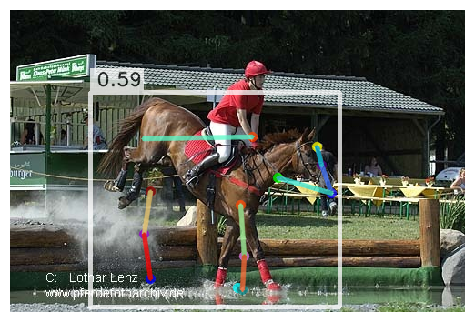

In [27]:
img_url = "/content/images/2007_000392.jpg"
best_model.predict(img_url, conf=0.20, fuse_model=False).show()

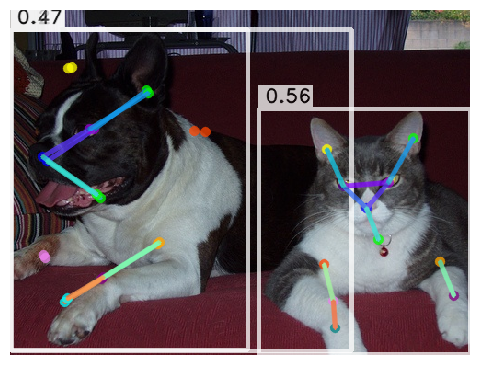

In [28]:
img_url = "/content/images/2007_000783.jpg"
best_model.predict(img_url, conf=0.20, fuse_model=False).show()

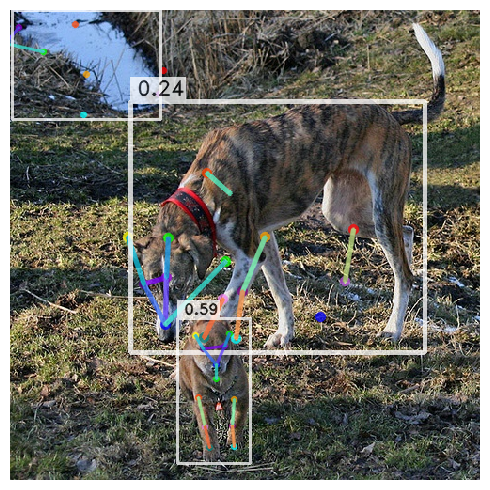

In [29]:
img_url = "/content/images/2007_009889.jpg"
best_model.predict(img_url, conf=0.20, fuse_model=False).show()

In [ ]:
img_url = "/content/images/2009_000565.jpg"
best_model.predict(img_url, conf=0.20, fuse_model=False).show()

#  🏁 Resume Training

If you want to continue training from the previously saved checkpoint all you have to do is set the `resume` parameter in training parameters to `True`, and increase the number of `max_epochs`.

Then you use the trainer, just like before

In [30]:
train_params["resume"] = True
train_params["max_epochs"] = 50

In [ ]:
trainer.train(model=yolo_nas_pose, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)